<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/split-step-fourier-method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
################### Physical Parameters  ########################
Ip = 4**2;                           #peak intensity
Ib = 1.0;                             #background illumination
Lambda = 0.5e-6;                      #wavelength
k0 = 2*np.pi/Lambda;                  #vacuum wavevector
n0 = 1;                               #background index of refraction
w0 = 0.5e-3;

Lz = 5;                               #computational length of sample
Lx = 30e-3;                           #computational width of sample

Chirp = -0.0*6*230000.0;              #input linear chirp parameter

# inputposition=-0*10^(-6);           #input position
h = 0.67e-3;
inputposition = +h/2;                 #input position

In [0]:
################## Computational Parameters #############

nstepx = 1*1024;                #number of transverse grid points
nstepz = 5;     #200            #number of longitudinal propagation steps
deltax = Lx/nstepx;
deltaz = Lz/nstepz;    #the resolution in the z direction, IMPORTANT
deltaf = 1/Lx;                  #spatial frequency step

In [0]:
##########################  GENERAL GRID SET-UP  ##########################

z = np.arange(0, Lz, deltaz)                #z grid
x = -Lx/2 + deltax/2+(np.arange(0, nstepx, 1))*deltax;                       # x array

X, Y = np.meshgrid(x,x);

In [0]:
##########################  Dispersive Step Setup #########################

ntx = 0;             
kx = np.zeros(nstepx)                                          #this is to get rid of fftshifts and the sort
for nn in range(nstepx):
    ikx = nn - ntx;
    kx[nn] = 2*np.pi*deltaf*ikx;
    if nn + 1 - nstepx/2 == 0 :
      ntx = nstepx;

KX, KY = np.meshgrid(kx, kx);

ArgumentOfPropagator  =  ((k0*n0)**(-1)*(KX**2+KY**2))*(deltaz/4.);                  #### propagao per dz/2 (il 4 � perch� c'� anche un fattore 2 nel propagatore)
Propagator = np.cos(ArgumentOfPropagator)+1j*np.sin(ArgumentOfPropagator);

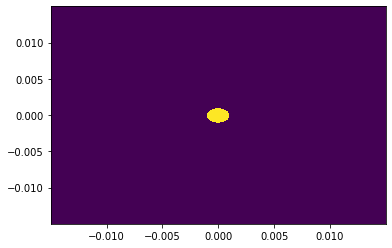

In [7]:
####################### INPUT FIELDS DEFINITION  #########################

# InputField = sqrt(Ip)*exp(i*Chirp*x-(x-inputposition).^2./(w0^2));    #input field shape
InputField = np.sqrt(Ip)*np.exp(-(X-0*inputposition)**2/(w0**2)-(Y-0*inputposition)**2/(w0**2));  #input field shape
InputField = 1+0*X;Radius = 1e-3;
InputField[np.sqrt(X**2+Y**2)>Radius] = 0;


# InputFields = sqrt(Ip)*(exp(-(x-inputposition).^20./(w0^20))+exp(-(x-inputposition+h).^20./(w0^20))); #input field shape
plt.pcolor(X,Y,InputField**2)

# [ZZ XX] = meshgrid(z,x);
# MatrixAppoggio = 0.*ZZ+NaN;
# MatrixAppoggio2 = 0.*ZZ+NaN;

MatrixAppoggio = np.zeros(shape=(nstepx, nstepx, nstepz))
MatrixAppoggio[..., 0] = np.abs(InputField)**2

In [0]:
fft2, ifft2= np.fft.fft2, np.fft.ifft2

In [0]:
####################################################################)#
######                    PROPAGATION LOOP                  ########
####################################################################
for hh in range(nstepz):
    
    ################### DISPERSIVE HALF STEP ############################
    
    InputFieldTransform = fft2(InputField)#, nstepx, nstepx);
    
    InputFieldTransform = InputFieldTransform*Propagator;
    InputField = ifft2(InputFieldTransform)#, nstepx, nstepx);
    
    ################### DISPERSIVE HALF STEP ############################
    InputFieldTransform = fft2(InputField)#, nstepx, nstepx);
    #InputFieldTransform = fftshift(InputFieldTransform);
    InputFieldTransform = InputFieldTransform*Propagator;
    InputField = ifft2(InputFieldTransform)#, nstepx, nstepx);
    #InputField = ifftshift(InputField);
    
  
    MatrixAppoggio[..., hh] = abs(InputField)**2;
    
inputpower = np.sum(MatrixAppoggio[...,1])
outputpower = np.sum(MatrixAppoggio[...,-1])

energy_gap = (outputpower-inputpower)/(outputpower+inputpower)
if energy_gap != 0:
  raise ValueError("Numerical Error: Energy is not conserved")

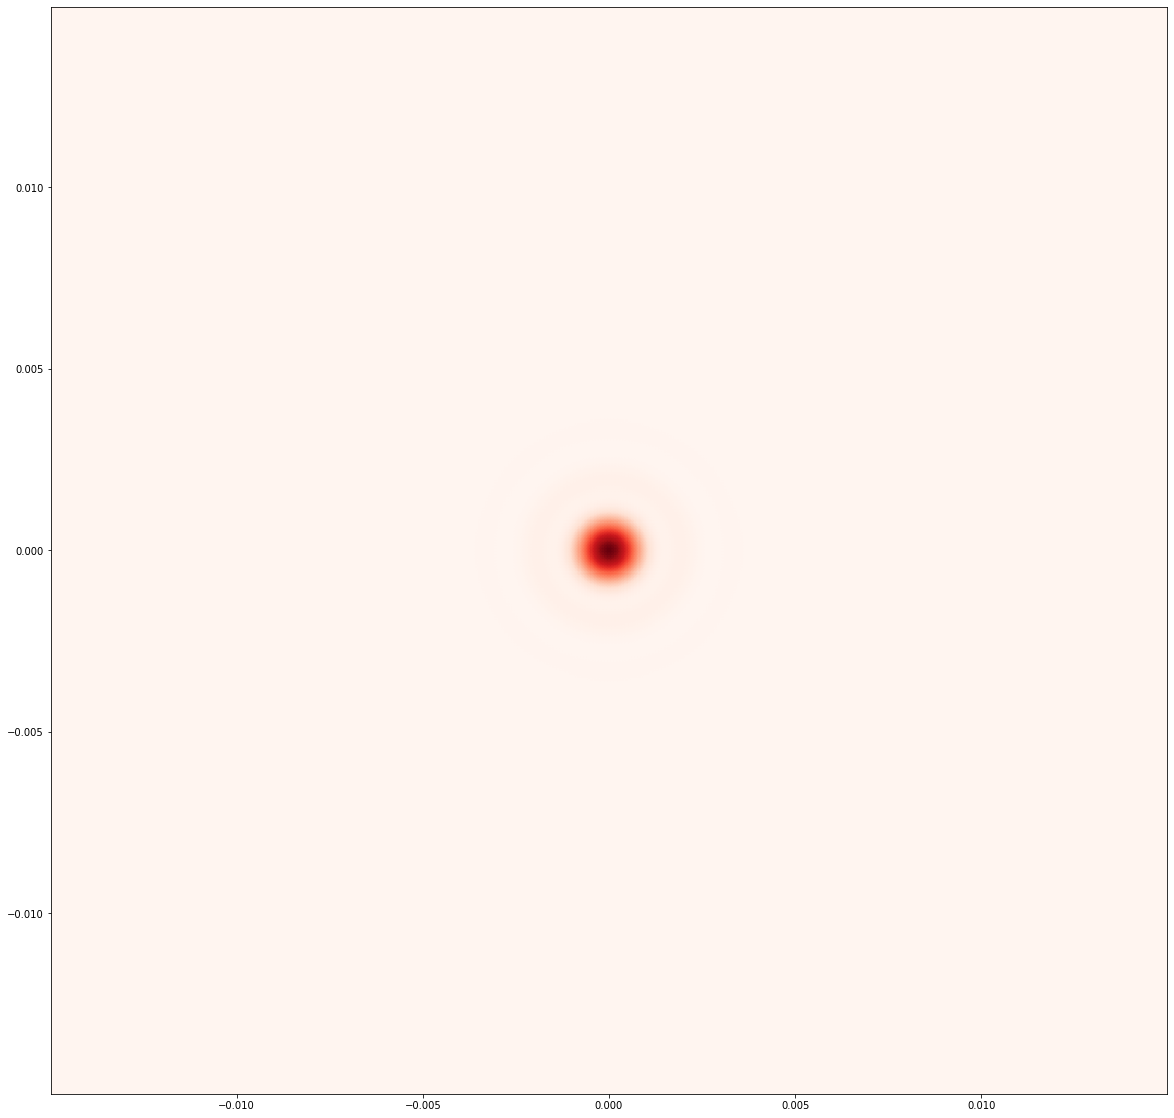

In [25]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.pcolor(X, Y, MatrixAppoggio[...,-1], cmap="Reds")